In [251]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [252]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Confidence in hypothesis

This notebook demonsrtrates the evolution of confidence in a hypothesis. Depending on the hypothesis configuration of a subgraph we compare it to the maximum confidence we can obtain from a bigger graph.

## Statistics of the hypothesis graph

Number of nodes and arcs of the hypothesis graph

In [253]:
from hypotest.setup_hypothgraph import sample_graphs

In [254]:
hypothgraph = sample_graphs.sample_hypothgraph()

In [255]:
nb_nodes = len(hypothgraph.nodes())
nb_arcs = len(hypothgraph.edges())

In [256]:
print("number of nodes {}, number of arcs {}".format(nb_nodes, nb_arcs))

number of nodes 37, number of arcs 47


## Hypothesis causal endpoints

Creation of a subgraph is a bit of *woodo* magic, we need to say what is the desired ratio of the paths from *source* to *target*, the causal endpoints of a hypothesis. So before we proceed we need the hypothesis configuration.

In [257]:
import networkx as nx

In [258]:
from hypotest.graph_generation import hypoth_conf

In [259]:
source, target = hypoth_conf.generate_rich_endpoints(hypothgraph)

In [260]:
print('number of paths from {} to {} is {}'.format(source, target, len(list(nx.all_simple_paths(hypothgraph, source, target)))))

number of paths from http://plumdeq.xyz/ontologies/hypothesis/Collagen_catabolism to http://plumdeq.xyz/ontologies/hypothesis/Biochemical_imbalance is 2


## Create a sub hypothesis graph

We deliberately choose a very small ratio of `on_boundary` paths, however we take some fair amount of paths within the hypothesis configuration.

In [261]:
from hypotest.graph_generation import sub_hypothgraph

In [262]:
ratio_on_boundary_paths = 0.01
ratio_endpoints_paths = 0.2

In [263]:
subgraph = sub_hypothgraph.generate_sub_hypothgraph(
    hypothgraph, source, target,
    ratio_endpoints_paths=ratio_endpoints_paths,
    ratio_on_boundary_paths=ratio_on_boundary_paths)

In [264]:
nb_sub_nodes = len(subgraph.nodes())
nb_sub_arcs = len(subgraph.edges())

In [265]:
print("number of nodes {}, number of arcs {}".format(nb_sub_nodes, nb_sub_arcs))

number of nodes 20, number of arcs 20


## Computing confidences

To compute the confidences in both sub and hypothgraphs we need to determine what are boundary interiors in both of the graphs.

### Confidence computation

Confidence is computed as the sum of all weighted paths from `source` to `target` normalized to the number of these weighted paths. Suppose `source` is $u$ and `target` is $v$.

$$
Confidence(u, v) = \frac{\sum_{\pi_i(u, v)} weighted\_path(\pi_i)}{len(\pi(u, v))}
$$

### Boundary interiors of the two graphs

In [266]:
from hypotest.graph_generation import boundary

In [267]:
sub_boundary_interior = list(boundary.in_boundary_interior(subgraph, source, target))

In [268]:
big_boundary_interior = list(boundary.in_boundary_interior(hypothgraph, source, target))

In [269]:
print("Nb nodes in the boundary interior (subgraph) {}), nb nodes in full boundary interior {}".format(
    len(sub_boundary_interior), len(big_boundary_interior)))

Nb nodes in the boundary interior (subgraph) 2), nb nodes in full boundary interior 10


### Confidence subgraph

In [270]:
from hypotest.stats import confidences

Confidence in the hypothesis as we gradually add more evidenced nodes from the boundary, inside the subgraph only

In [271]:
sub_confidences = confidences.confidence_spectrum(subgraph, source, target)
sub_confidences

[0.0, 1.0, 2.0]

In [272]:
sub_confidences_normalized = confidences.confidence_spectrum(subgraph, source, target, normalized=True)
sub_confidences_normalized

[0.0, 0.5, 1.0]

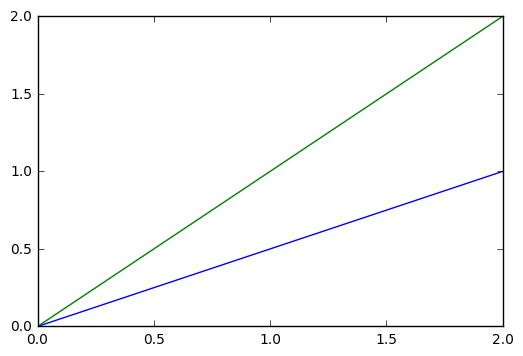

In [273]:
plt.plot(sub_confidences_normalized)
plt.plot(sub_confidences)

### Confidence bigraph 

In [274]:
big_confidences = confidences.confidence_spectrum(hypothgraph, source, target)
big_confidences

[0.0, 0.5, 1.5, 2.0, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

In [275]:
big_confidences_normalized = confidences.confidence_spectrum(hypothgraph, source, target, normalized=True)
big_confidences_normalized

[0.0,
 0.08333333333333333,
 0.25,
 0.3333333333333333,
 0.5,
 0.5833333333333334,
 0.6666666666666666,
 0.75,
 0.8333333333333334,
 0.9166666666666666,
 1.0]

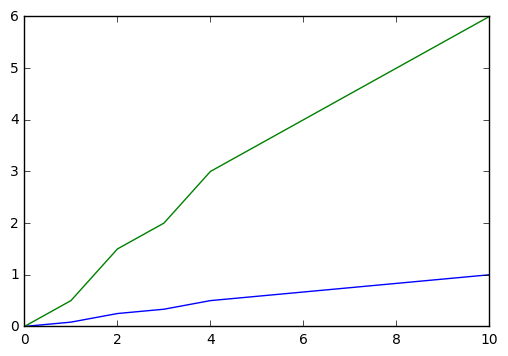

In [276]:
plt.plot(big_confidences_normalized)
plt.plot(big_confidences)

## Relative confidence values

Here we check confidence values which can be obtained withing the small graph, normalized to the max confidence inside the small graph, as well as normalized to the max in the big graph

In [277]:
import pandas as pd

In [278]:
relative_spectrum = confidences.relative_confidence_spectrum(hypothgraph, subgraph, source, target)

In [279]:
relative_spectrum_df = pd.DataFrame(relative_spectrum)

In [280]:
relative_spectrum_df

,big_confidence_normalized_spectrum,big_confidence_spectrum,sub_confidence_normalized_spectrum,sub_confidence_spectrum
0,0.000000,0.0,0.0,0.0
1,0.166667,1.0,0.5,1.0
2,0.333333,2.0,1.0,2.0


## Draw this configuration

In [281]:
from hypotest.io import write_dot

In [285]:
current_conf = './images/subgraphs/current_conf.dot'

In [286]:
with open(current_conf, 'w') as f:
    write_dot.to_dot(hypothgraph, subgraph, source, target, stream=f)